In [700]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [701]:

data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data.head(5))

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
01/01/2008               0.0        23.230         90.200  
02/01/2008               0.0        26.239        213.791  
03/01/2008               0.0        24.000        175.000  
04/01/2008               0.0        11.000        164.000  
05/01/2008               0.0        24.000        177.000  


In [702]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [703]:
# def create_sequences(data, seq_length):
#     sequences = []
#     targets = []
#     for i in range(len(data) - seq_length):
#         sequences.append(data[i:i + seq_length])
#         targets.append(data[i + seq_length, 0])  
#     return np.array(sequences), np.array(targets)

In [704]:
sequence_length = 1 # Sử dụng 30 ngày để dự đoán
X, y = [], []
# X chứa dữ liệu đầu vào của 7 ngày trc trong file 
#y chứa dữ liệu mà ta muốn dự doán cho ngày kế tiếp ở đây sẽ là dữ liệu kế tiếp sau 7 ngày 
# Ví dụ:
# dữ liệu 7 ngày : 
#      mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
# Ngay                                                                     
# 01/01/2008        120        498.815         259.499               0.0   
# 02/01/2008        117        470.866         518.755               0.0   
# 03/01/2008        139        423.816         615.242               0.0   
# 04/01/2008        166        496.882         902.982               0.0   
# 05/01/2008        179        501.232        1072.970               0.0   
# 06/01/2008        199        346.358         393.919               0.0   
# 07/01/2008        190        421.766        1109.965               0.0 
# Sẽ là dữ liệu X 
# Dữ liệu này kế tiếp : 
# 08/01/2008        178        423.221        1037.933               0.0   
#Sẽ là y 
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i])

X, y = np.array(X), np.array(y)

In [705]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [706]:
output_dim = X_train.shape[2]
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(output_dim)
])

In [707]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 64)                18432     
                                                                 
 dense_27 (Dense)            (None, 7)                 455       
                                                                 
Total params: 18887 (73.78 KB)
Trainable params: 18887 (73.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [708]:
# 3. Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 3s 10ms/step - loss: 0.0399 - val_loss: 0.0158
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0116 - val_loss: 0.0132
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0094 - val_loss: 0.0111
Epoch 4/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0081 - val_loss: 0.0095
Epoch 5/50
64/64 [==============================] - 0s 3ms/step - loss: 0.0072 - val_loss: 0.0082
Epoch 6/50
64/64 [==============================] - 0s 5ms/step - loss: 0.0064 - val_loss: 0.0075
Epoch 7/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0059 - val_loss: 0.0069
Epoch 8/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0055 - val_loss: 0.0065
Epoch 9/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0053 - val_loss: 0.0062
Epoch 10/50
64/64 [==============================] - 0s 4ms/step - loss: 0.0051 - val_loss: 0.0060
Epoch 11/50
64/64 

In [709]:
# Hàm tính Nash-Sutcliffe Efficiency (NSE)
def nse(y_true, y_pred):
    numerator = np.sum((y_true - y_pred) ** 2)
    denominator = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - numerator / denominator

In [710]:
# Dự đoán
y_pred = model.predict(X_test)

# Chuyển đổi kích thước y_pred để phù hợp với y_test
y_pred = y_pred.reshape(y_pred.shape[0], -1)  # Biến đổi thành mảng 2 chiều
y_test_reduced = y_test[:, 0]# Lấy cột đầu tiên nếu y_pred có nhiều cột

# Giảm số lượng mẫu của y_pred và y_test xuống còn 512 mẫu
y_pred_reduced = y_pred[:512]  # Cắt y_pred để chỉ lấy 512 mẫu đầu tiên
y_test_reduced = y_test[:512]  # Cắt y_test để chỉ lấy 512 mẫu đầu tiên
print("Kích thước y_pred_reduced:", y_pred_reduced.shape)
print("Kích thước y_test_reduced:", y_test_reduced.shape)

# Tính toán các chỉ số
r2 = r2_score(y_test_reduced, y_pred_reduced)
print("R² (R-squared):", r2)

mae = mean_absolute_error(y_test_reduced, y_pred_reduced)
print("MAE (Mean Absolute Error):", mae)

rmse = np.sqrt(mean_squared_error(y_test_reduced, y_pred_reduced))
print("RMSE (Root Mean Square Error):", rmse)

nse = nse(y_test_reduced, y_pred_reduced)
print("NSE (Nash-Sutcliffe Efficiency):", nse)


16/16 [==============================] - 0s 2ms/step
Kích thước y_pred_reduced: (512, 7)
Kích thước y_test_reduced: (512, 7)
R² (R-squared): 0.7932543042414347
MAE (Mean Absolute Error): 0.0425140806981109
RMSE (Root Mean Square Error): 0.07451882073877847
NSE (Nash-Sutcliffe Efficiency): 0.8664703483089339


In [711]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data['Ngay'] = pd.to_datetime(new_data['Ngay'], format='%d/%m/%Y')
new_data.set_index('Ngay', inplace=True)
print(new_data)

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
2015-01-01         85        575.000         757.694             120.0   
2015-01-02        114        840.327        1045.743             116.0   
2015-01-03        141       1059.445         976.320             115.0   
2015-01-04        147        576.221         671.221             115.0   
2015-01-05        135        875.634         946.884             116.0   
...               ...            ...             ...               ...   
2017-01-03        160        280.500         720.369              82.0   
2017-01-04        120        270.500         600.369              79.0   
2017-01-05        140        260.500         740.369              76.0   
2017-01-06        200        230.500         701.369              90.0   
2017-01-07        210        240.500         760.369              74.0   

            chayMayTuyenQuan  nuocVeT

In [712]:
data_test_scaled = scaler.transform(new_data)
# Chia dữ liệu mới thành chuỗi thời gian
# Tạo các mẫu test từ dữ liệu test
# Chia dữ liệu mới thành chuỗi thời gian
X_new,Y_new = [],[]
for i in range(sequence_length, len(data_test_scaled)):
    X_new.append(data_test_scaled[i-sequence_length:i])
    Y_new.append(data_test_scaled[i])
X_new = np.array(X_new)
print(len(X_new))
y_new = np.array(Y_new)

737


In [713]:
predictions = model.predict(X_new)
predictions_new_original = scaler.inverse_transform(predictions)[:,0]
y_test_new_original = scaler.inverse_transform(y_new)[:,0]
print(y_test_new_original )

24/24 [==============================] - 0s 2ms/step
[114. 141. 147. 135. 127. 126. 120. 135. 141. 164. 185. 181. 164. 140.
 124. 163. 218. 231. 230. 232. 233. 235. 195. 125.  79.  58. 107. 201.
 233. 236. 235. 237. 237. 231. 230. 195. 139.  87.  75.  76. 118. 185.
 211. 219. 230. 203. 134. 109. 107. 115. 108.  80.  69.  48.  50.  53.
  73.  87.  97.  97. 102.  93.  85.  94.  87.  71.  62.  56.  65.  73.
  77.  88. 100. 116. 108. 109. 107. 110. 105.  99.  90.  93.  99. 119.
 139. 148. 143. 139. 131. 137. 156. 168. 162. 167. 171. 172. 166. 164.
 172. 178. 184. 182. 199. 212. 212. 191. 183. 178. 174. 172. 171. 186.
 178. 166. 177. 187. 161. 131. 146. 167. 162. 150. 162. 180. 201. 208.
 217. 219. 218. 226. 232. 242. 243. 227. 227. 252. 259. 262. 272. 291.
 297. 305. 312. 294. 296. 292. 272. 255. 250. 243. 216. 203. 233. 246.
 251. 251. 258. 228. 212. 217. 212. 207. 201. 183. 178. 165. 188. 185.
 170. 155. 150. 142. 141. 156. 177. 184. 194. 199. 176. 162. 168. 191.
 218. 222. 229. 198. 197

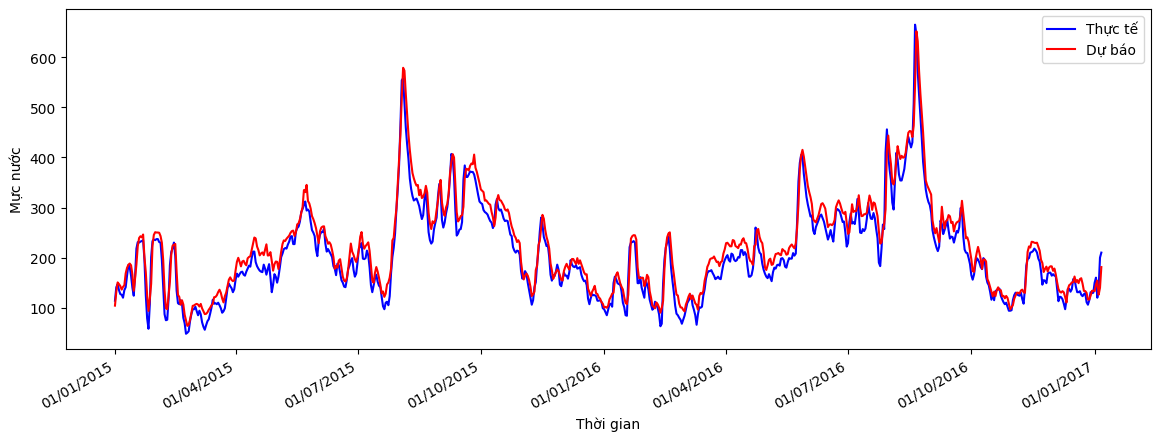

In [714]:
import matplotlib.dates as mdates

min_length = min(len(new_data.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = new_data.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

In [715]:
# Tạo mảng ngày bắt đầu từ chỉ số sequence_length của new_data
dates = new_data.index[sequence_length:]

# Đảm bảo số lượng phần tử của dự báo và thực tế khớp với số lượng ngày
min_length = min(len(dates), len(predictions_new_original), len(y_test_new_original))

# Cắt ngắn các mảng để khớp số phần tử nếu cần
dates = dates[:min_length]
predictions_new_original = predictions_new_original[:min_length]
y_test_new_original = y_test_new_original[:min_length]

# Tạo DataFrame với ngày, thực tế và dự báo
df_mucNuocHN = pd.DataFrame({
    'Ngay': dates,
    'ThucTe': y_test_new_original,
    'DuBao': predictions_new_original
})

# Đặt cột 'Ngay' làm chỉ mục
df_mucNuocHN.set_index('Ngay', inplace=True)

# Đặt tên đa cấp cho các cột với nhóm 'mucNuocHaNoi'
df_mucNuocHN.columns = pd.MultiIndex.from_product([['mucNuocHaNoi'], ['ThucTe', 'DuBao']])

# Hiển thị DataFrame
print(df_mucNuocHN)


           mucNuocHaNoi            
                 ThucTe       DuBao
Ngay                               
2015-01-02        114.0  104.170288
2015-01-03        141.0  131.920044
2015-01-04        147.0  150.506470
2015-01-05        135.0  147.168869
2015-01-06        127.0  143.123688
...                 ...         ...
2017-01-03        160.0  146.410431
2017-01-04        120.0  154.079361
2017-01-05        140.0  126.007797
2017-01-06        200.0  139.749405
2017-01-07        210.0  181.089355

[737 rows x 2 columns]
